In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


In [5]:
# We'll use the German Credit Dataset which is publicly available
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
column_names = ['status', 'duration', 'credit_history', 'purpose', 'amount', 'savings', 'employment_duration',
                'installment_rate', 'personal_status_sex', 'other_debtors', 'present_residence', 'property',
                'age', 'other_installment_plans', 'housing', 'number_credits', 'job', 'people_liable',
                'telephone', 'foreign_worker', 'credit_risk']


In [7]:
df = pd.read_csv(url, sep=' ', header=None, names=column_names)

In [9]:
# Convert target variable to binary (0: good, 1: bad)
# In this dataset, 1 = good credit risk, 2 = bad credit risk
df['credit_risk'] = df['credit_risk'].map({1: 0, 2: 1})

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows of the dataset:")
df.head()

Dataset loaded successfully!
Dataset shape: (1000, 21)

First 5 rows of the dataset:


,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1


([<matplotlib.axis.XTick at 0x12e40d640>,
 [Text(0, 0, 'Good Credit (0)'), Text(1, 0, 'Bad Credit (1)')])

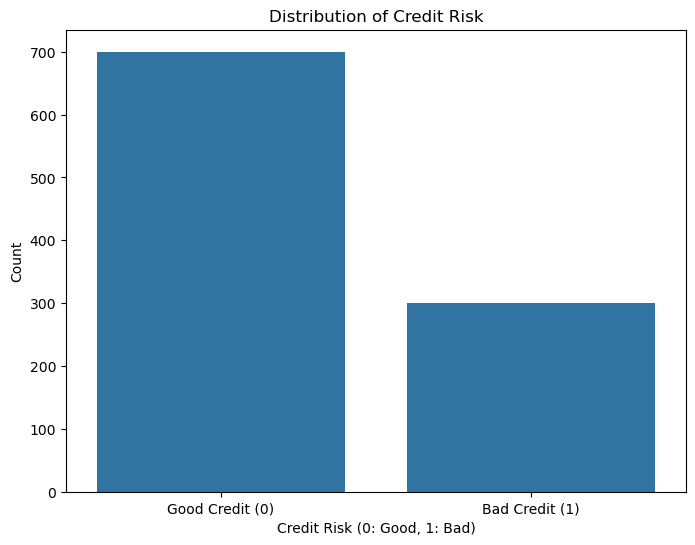

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(x='credit_risk', data=df)
plt.title('Distribution of Credit Risk')
plt.xlabel('Credit Risk (0: Good, 1: Bad)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Good Credit (0)', 'Bad Credit (1)'])

In [13]:
# Print exact counts and percentages
risk_counts = df['credit_risk'].value_counts()
print("\nClass Distribution:")
print(f"Good Credit (0): {risk_counts[0]} ({risk_counts[0]/len(df)*100:.2f}%)")
print(f"Bad Credit (1): {risk_counts[1]} ({risk_counts[1]/len(df)*100:.2f}%)")
plt.show()


Class Distribution:
Good Credit (0): 700 (70.00%)
Bad Credit (1): 300 (30.00%)


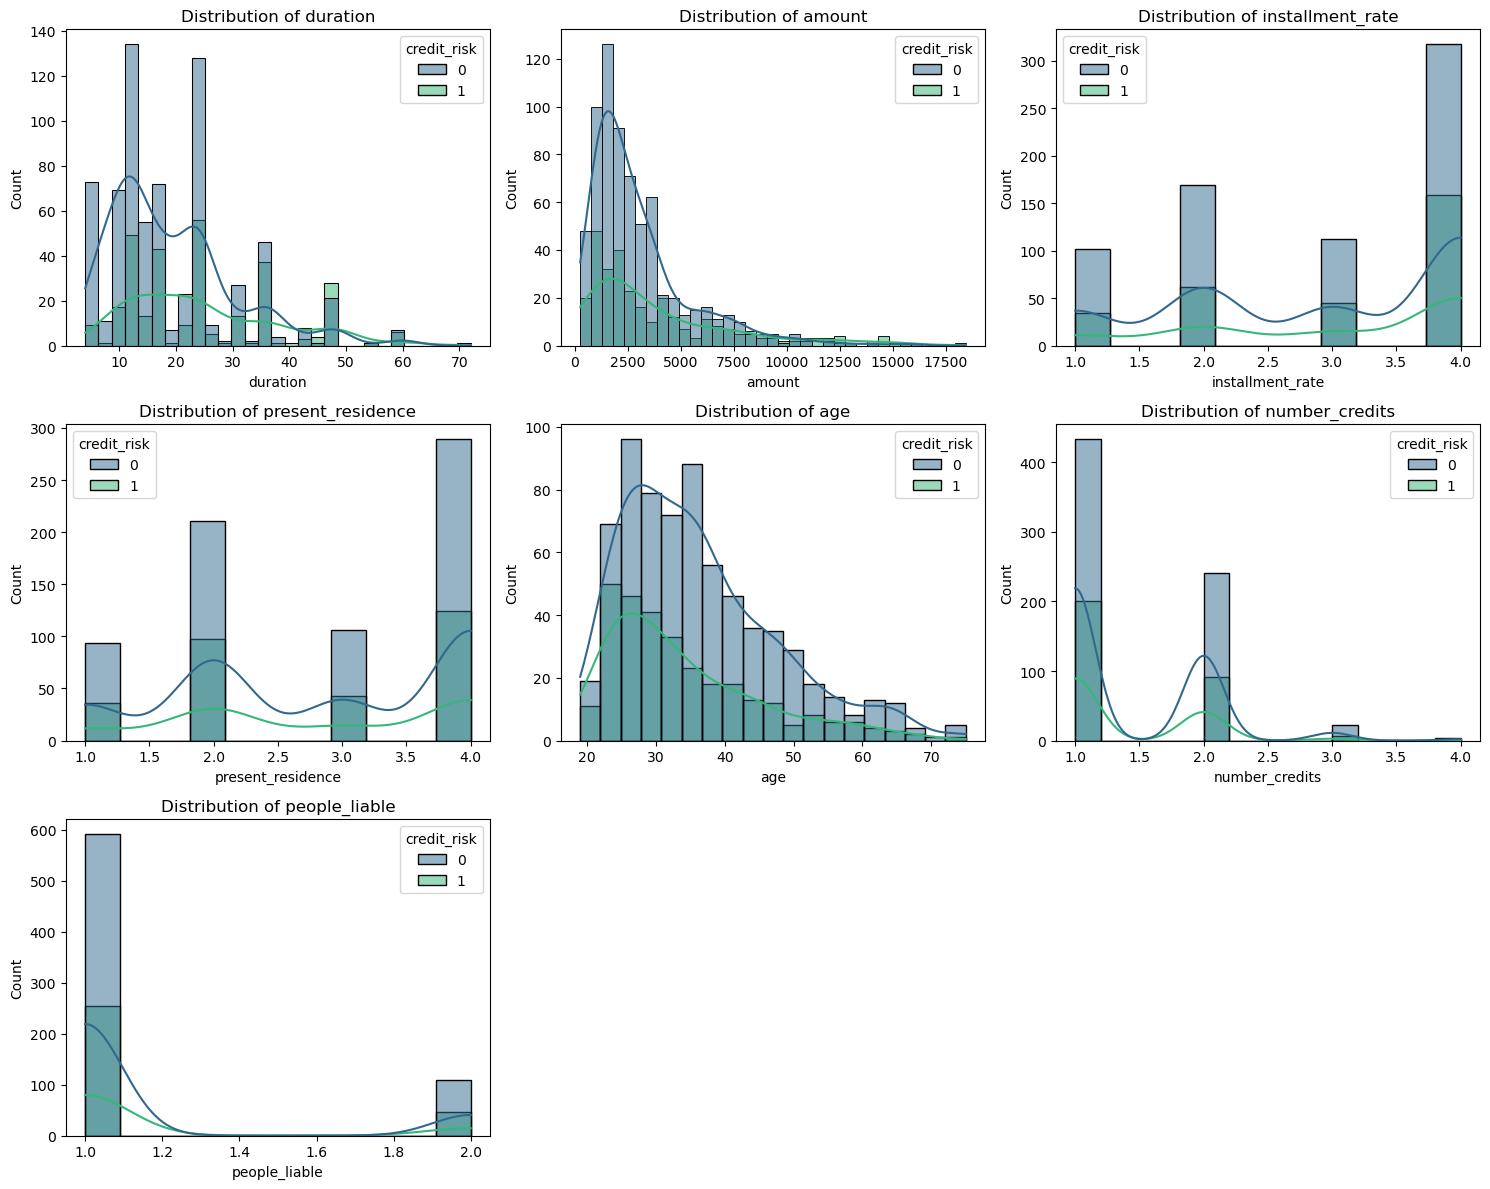

In [15]:
numeric_features = ['duration', 'amount', 'installment_rate', 'present_residence', 'age', 'number_credits', 'people_liable']

plt.figure(figsize=(15, 12))
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=df, x=feature, hue='credit_risk', kde=True, palette='viridis')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

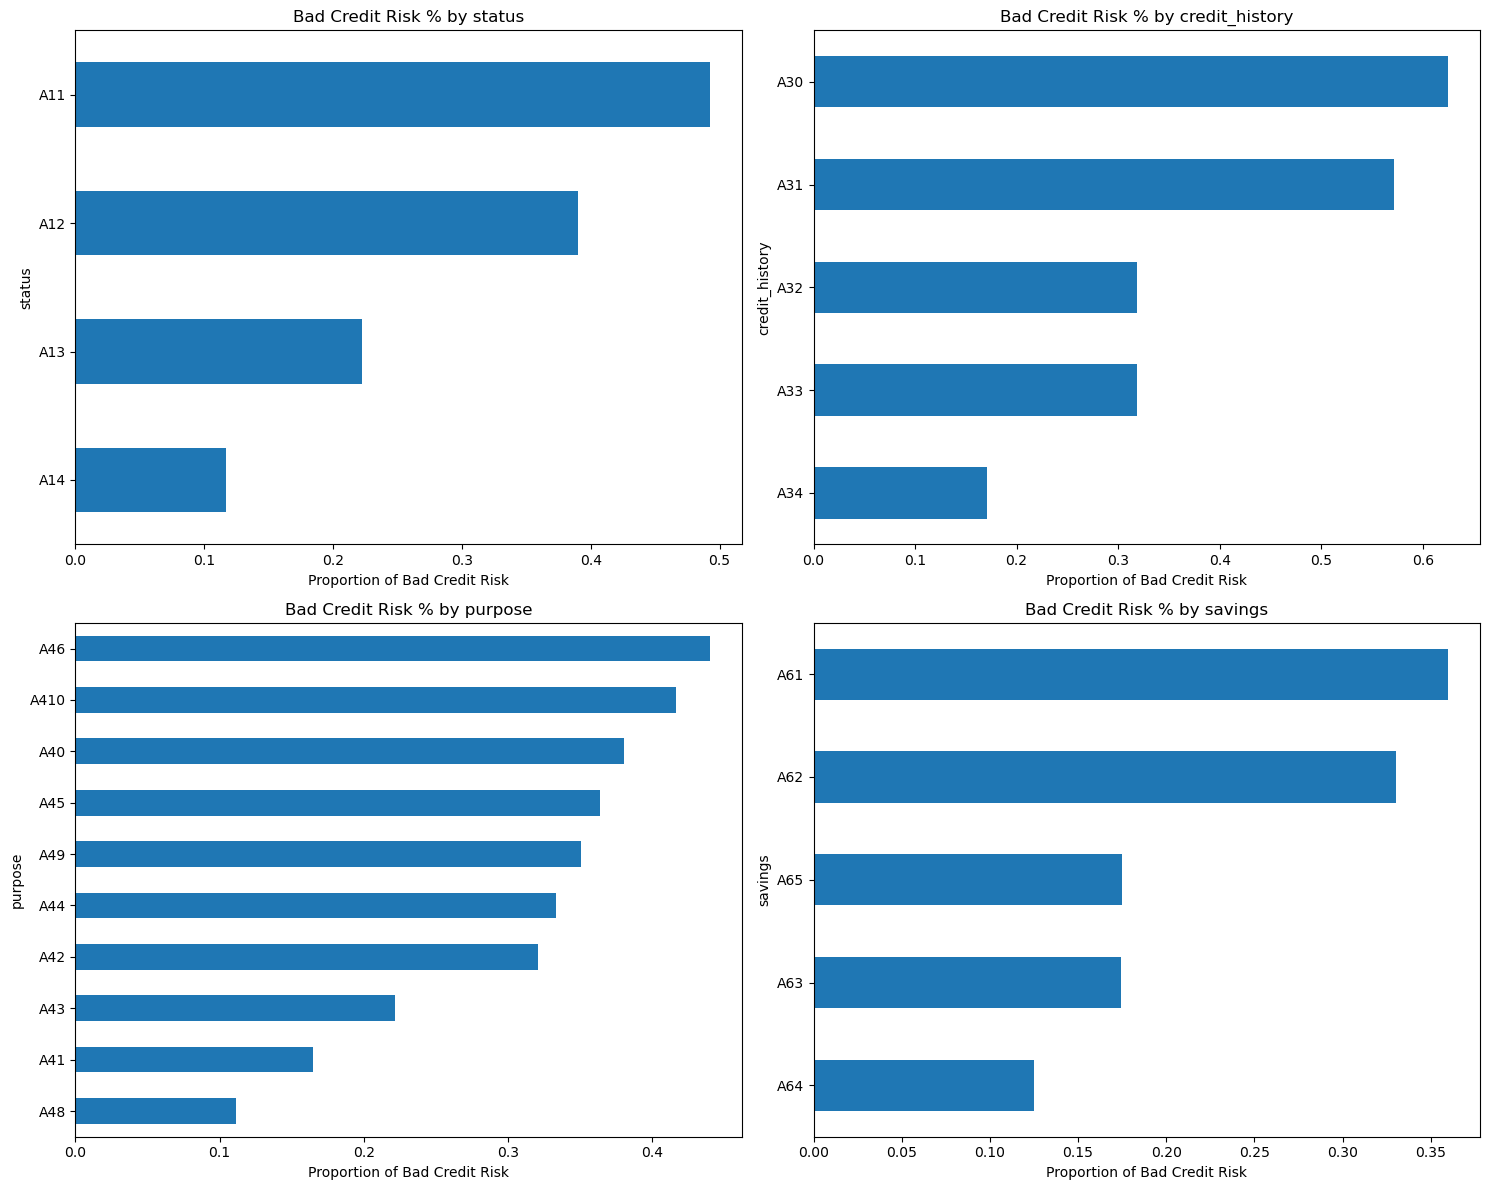

In [25]:
categorical_features = ['status', 'credit_history', 'purpose', 'savings', 'employment_duration',
                        'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans',
                        'housing', 'job', 'telephone', 'foreign_worker']
# Let's look at a few important categorical features
plt.figure(figsize=(15, 12))
for i, feature in enumerate(['status', 'credit_history', 'purpose', 'savings']):
    plt.subplot(2, 2, i+1)
    # Calculate percentages of bad credit for each category
    risk_by_cat = pd.crosstab(df[feature], df['credit_risk'], normalize='index')
    risk_by_cat[1].sort_values().plot(kind='barh')
    plt.title(f'Bad Credit Risk % by {feature}')
    plt.xlabel('Proportion of Bad Credit Risk')
plt.tight_layout()
plt.show()

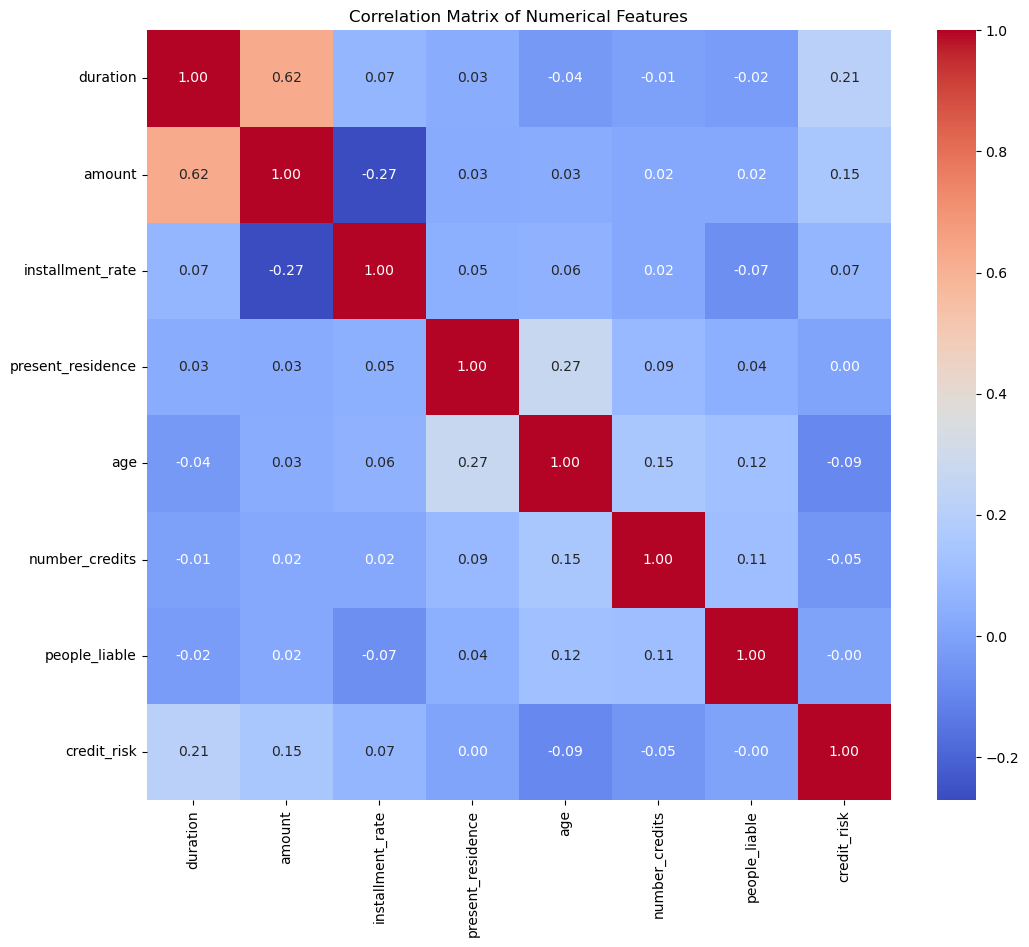

In [27]:
plt.figure(figsize=(12, 10))
numerical_df = df[numeric_features + ['credit_risk']]
correlation = numerical_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [29]:
# Separate features and target
X = df.drop('credit_risk', axis=1)
y = df['credit_risk']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nCategorical features:", categorical_features)
print("\nNumerical features:", numerical_features)


Training set shape: (800, 20)
Testing set shape: (200, 20)

Categorical features: ['status', 'credit_history', 'purpose', 'savings', 'employment_duration', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']

Numerical features: ['duration', 'amount', 'installment_rate', 'present_residence', 'age', 'number_credits', 'people_liable']


In [31]:
# Create transformers for categorical and numerical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Create and fit preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

# Fit the model
model.fit(X_train, y_train)
print("Model training complete!")

Model training complete!


Accuracy: 0.7800

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       140
           1       0.67      0.53      0.59        60

    accuracy                           0.78       200
   macro avg       0.74      0.71      0.72       200
weighted avg       0.77      0.78      0.77       200



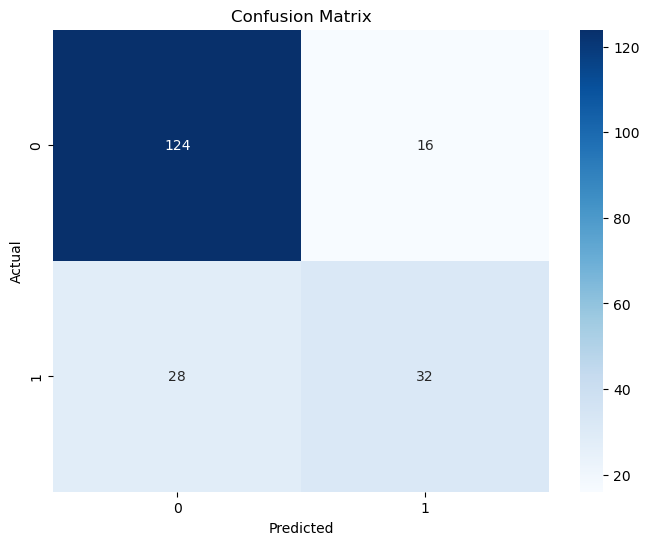

In [33]:
# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

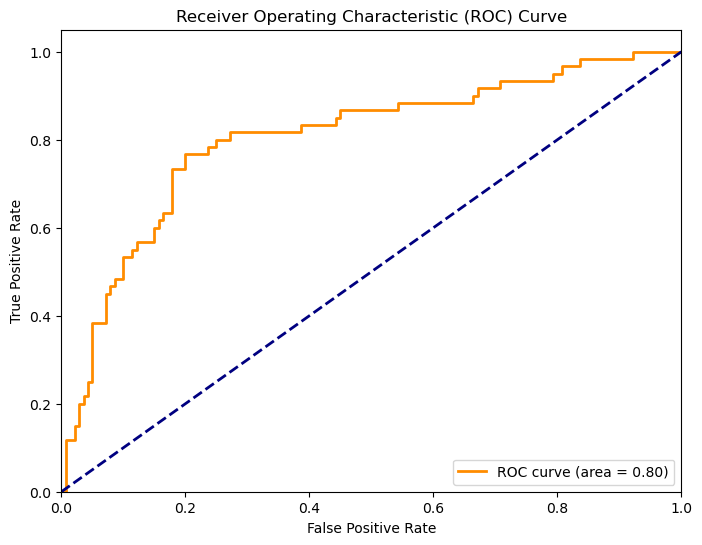

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

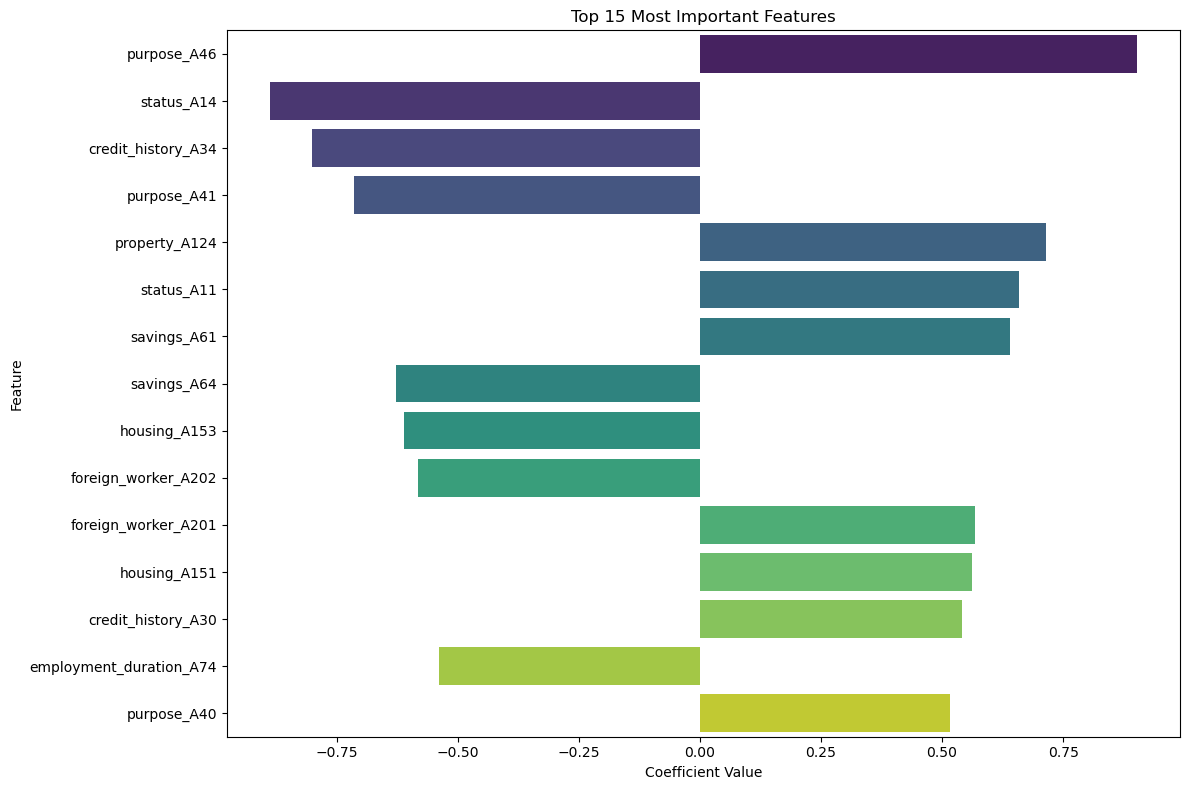

In [37]:
# Get feature names from preprocessor
feature_names = []
# Extract all feature names from the preprocessing pipeline
for name, estimator, features in model.named_steps['preprocessor'].transformers_:
    if name == 'cat':
        feature_names.extend([f"{feature}_{category}" for feature, categories in 
                              zip(features, estimator.categories_) for category in categories])
    else:
        feature_names.extend(features)

# Get coefficients
coefficients = model.named_steps['classifier'].coef_[0]

# Create a DataFrame to store feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Plot top 15 most important features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='viridis')
plt.title('Top 15 Most Important Features')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

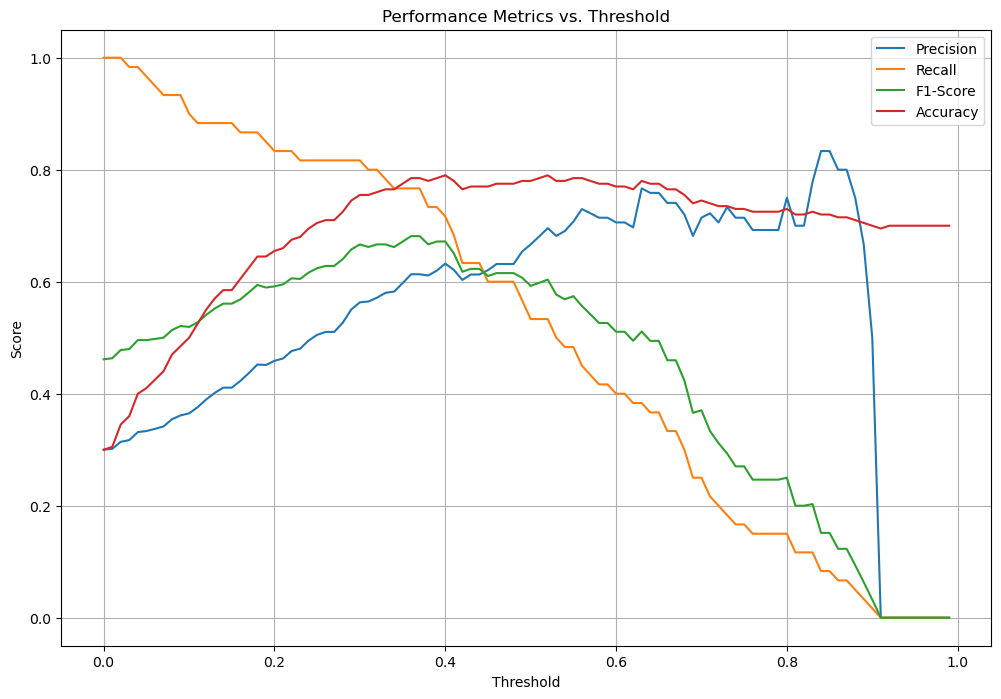

In [39]:
thresholds = np.arange(0, 1, 0.01)
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

from sklearn.metrics import precision_score, recall_score, f1_score

for threshold in thresholds:
    y_pred_threshold = (y_prob >= threshold).astype(int)
    precision_scores.append(precision_score(y_test, y_pred_threshold, zero_division=0))
    recall_scores.append(recall_score(y_test, y_pred_threshold))
    f1_scores.append(f1_score(y_test, y_pred_threshold))
    accuracy_scores.append(accuracy_score(y_test, y_pred_threshold))

plt.figure(figsize=(12, 8))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.plot(thresholds, accuracy_scores, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

Optimal threshold based on F1-Score: 0.36

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       140
           1       0.61      0.77      0.68        60

    accuracy                           0.79       200
   macro avg       0.75      0.78      0.76       200
weighted avg       0.81      0.79      0.79       200



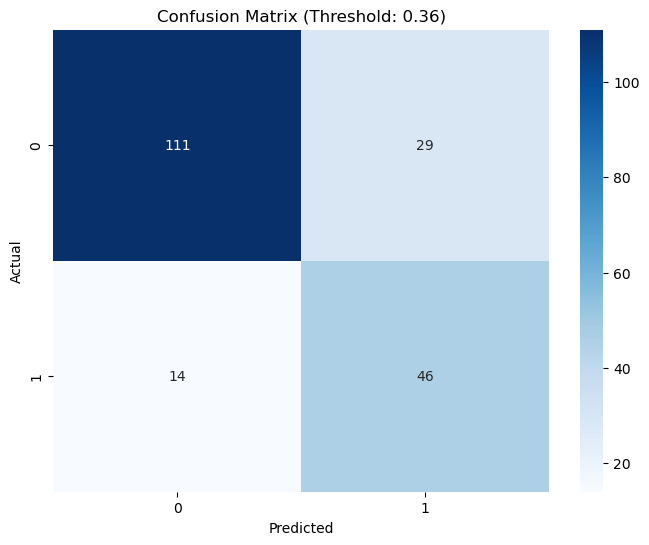

In [41]:
# Find the threshold that maximizes F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold based on F1-Score: {optimal_threshold:.2f}")

# Apply optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

# Plot confusion matrix with optimal threshold
plt.figure(figsize=(8, 6))
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Threshold: {optimal_threshold:.2f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [47]:
# Selecting a few real examples for interpretation
sample_indices = np.random.choice(X_test.index, 5, replace=False)
samples = X_test.loc[sample_indices]
true_labels = y_test.loc[sample_indices]
probabilities = model.predict_proba(samples)[:, 1]
predictions = (probabilities >= optimal_threshold).astype(int)

result_df = pd.DataFrame({'True Label': true_labels,
                          'Predicted': predictions,
                          'Probability of Bad Credit': probabilities})

In [45]:
# Add some key features for context
for feature in ['amount', 'age', 'duration']:
    if feature in samples.columns:
        result_df[feature] = samples[feature].values

print("Sample predictions:")
print(result_df)

print("\nConclusion:")
print("We've successfully built and evaluated a logistic regression model for credit risk assessment.")
print(f"The model achieved an accuracy of {accuracy:.2f} and an AUC score of {roc_auc:.2f}.")
print(f"By tuning the threshold to {optimal_threshold:.2f}, we can optimize our classification for this imbalanced dataset.")
print("The most important features affecting credit risk include duration of credit, credit amount, and credit history.")

Sample predictions:
     True Label  Predicted  Probability of Bad Credit  amount  age  duration
83            0          0                   0.246384    1755   58        24
194           1          1                   0.444906    3031   21        45
966           1          0                   0.150162    2520   23        27
993           0          1                   0.626130    3959   30        36
562           0          0                   0.329411     683   29         6

Conclusion:
We've successfully built and evaluated a logistic regression model for credit risk assessment.
The model achieved an accuracy of 0.78 and an AUC score of 0.80.
By tuning the threshold to 0.36, we can optimize our classification for this imbalanced dataset.
The most important features affecting credit risk include duration of credit, credit amount, and credit history.
